# Importing Necessary Libraries

In [1]:
# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

In [2]:
# Libraries for Classification and building Models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
# Project Specific Libraries

import os
import librosa
import librosa.display
import glob 
import skimage

# Analysing Data Type and Format

#### Analysing CSV Data

In [4]:
df = pd.read_csv("../input/urbansound8k/UrbanSound8K.csv")

'''We will extract classes from this metadata.'''

df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


##### Column Names

* slice_file_name: 
The name of the audio file. The name takes the following format: [fsID]-[classID]-[occurrenceID]-[sliceID].wav, where:
[fsID] = the Freesound ID of the recording from which this excerpt (slice) is taken
[classID] = a numeric identifier of the sound class (see description of classID below for further details)
[occurrenceID] = a numeric identifier to distinguish different occurrences of the sound within the original recording
[sliceID] = a numeric identifier to distinguish different slices taken from the same occurrence

* fsID:
The Freesound ID of the recording from which this excerpt (slice) is taken

* start
The start time of the slice in the original Freesound recording

* end:
The end time of slice in the original Freesound recording

* salience:
A (subjective) salience rating of the sound. 1 = foreground, 2 = background.

* fold:
The fold number (1-10) to which this file has been allocated.

* classID:
A numeric identifier of the sound class:
0 = air_conditioner
1 = car_horn
2 = children_playing
3 = dog_bark
4 = drilling
5 = engine_idling
6 = gun_shot
7 = jackhammer
8 = siren
9 = street_music

* class:
The class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, 
siren, street_music.

#### Using Librosa to analyse random sound sample - SPECTOGRAM

In [5]:
dat1, sampling_rate1 = librosa.load('../input/urbansound8k/fold5/100032-3-0-0.wav')
dat2, sampling_rate2 = librosa.load('../input/urbansound8k/fold5/100263-2-0-117.wav')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

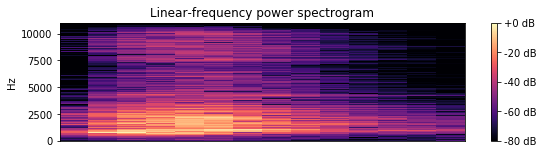

In [6]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat1)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

Text(0.5, 1.0, 'Linear-frequency power spectrogram')

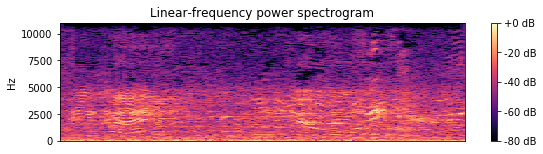

In [7]:
plt.figure(figsize=(20, 10))
D = librosa.amplitude_to_db(np.abs(librosa.stft(dat2)), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

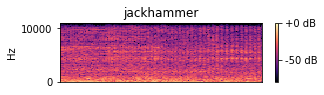

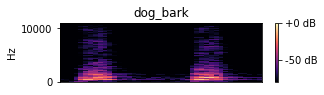

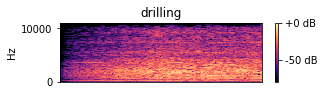

In [8]:
'''Using random samples to observe difference in waveforms.'''

arr = np.array(df["slice_file_name"])
fold = np.array(df["fold"])
cla = np.array(df["class"])

for i in range(192, 197, 2):
    path = '../input/urbansound8k/fold' + str(fold[i]) + '/' + arr[i]
    data, sampling_rate = librosa.load(path)
    plt.figure(figsize=(10, 5))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
    plt.subplot(4, 2, 1)
    librosa.display.specshow(D, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(cla[i])

# Feature Extraction and Database Building

#### Method

1. I have used Librosa to extract features.
2. To do so, I will go through each fold and extract the data for each file. Then I have used the mel_spectogram function of librosa to extract the spectogram data as a numpy array.
3. After reshaping and cleaning the data, 75-25 split has been performed.
4. Classes (Y) have been converted to Categorically Encoded Data usng Keras.utils

Note : Running the parser function may take upto 45 minutes depending on your system since it has to extract spectogram data for 8732 audio files

In [9]:
'''EXAMPLE'''

dat1, sampling_rate1 = librosa.load('../input/urbansound8k/fold5/100032-3-0-0.wav')
arr = librosa.feature.melspectrogram(y=dat1, sr=sampling_rate1)
arr.shape

(128, 14)

In [10]:
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in range(8732):
        file_name = '../input/urbansound8k/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [11]:
temp = parser(df)

In [12]:
temp = np.array(temp)
data = temp.transpose()

In [13]:
X_ = data[:, 0]
Y = data[:, 1]
print(X_.shape, Y.shape)
X = np.empty([8732, 128])

(8732,) (8732,)


In [14]:
for i in range(8732):
    X[i] = (X_[i])

In [15]:
Y = to_categorical(Y)

In [16]:
'''Final Data'''
print(X.shape)
print(Y.shape)

(8732, 128)
(8732, 10)


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)

In [18]:
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)

In [19]:
input_dim = (16, 8, 1)